In [1]:
# Original source: https://towardsdatascience.com/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# from pathlib import Path
# sys.path.append('/content/drive/MyDrive/RCNN_proj')
# path = Path('/content/drive/MyDrive/RCNN_proj')

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
# To reload module
# import importlib
# importlib.reload(rcnn_utils)

In [5]:
from pathlib import Path
path = Path('/home/pc0/projects/RCNN_proj/rcnn_proj')

In [6]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

import rcnn_utils
import rcnn_model
import image_utils
from object_detection_dataset import ObjectDetectionDataset

In [7]:
# Create dataset object
annotation_path = path.joinpath('data/annotations.xml')
img_dir = path.joinpath('data/images')
name2index = {'pad': -1, 'camel': 0, 'bird': 1}
index2name = {-1: 'pad', 0: 'camel', 1: 'bird'}
img_width = 640
img_height = 480

dset = ObjectDetectionDataset(
    annotation_path, img_dir, (img_width, img_height), name2index)

print(dset.bboxes)
print(dset.labels)
print(dset.img_paths, '\n')
print(dset[0][0].shape)

tensor([[[ 32.2824,  65.2389, 328.1726, 352.8849],
         [408.5333, 148.9911, 612.8032, 368.4920],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000]],

        [[413.2392, 208.3540, 566.8173, 323.4655],
         [215.0369, 221.7805, 418.7608, 446.4885],
         [182.7765,  53.6920, 348.1380, 213.6991],
         [ 58.8863, 116.6513, 271.8745, 307.2566],
         [281.0667, 182.5133, 429.0196, 273.1859],
         [ 65.0447, 322.8672, 226.2996, 453.4159]]])
tensor([[ 0.,  0., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.]])
[PosixPath('/home/pc0/projects/RCNN_proj/rcnn_proj/data/images/0462.png'), PosixPath('/home/pc0/projects/RCNN_proj/rcnn_proj/data/images/0896.png')] 

torch.Size([3, 480, 640])


<Axes: >

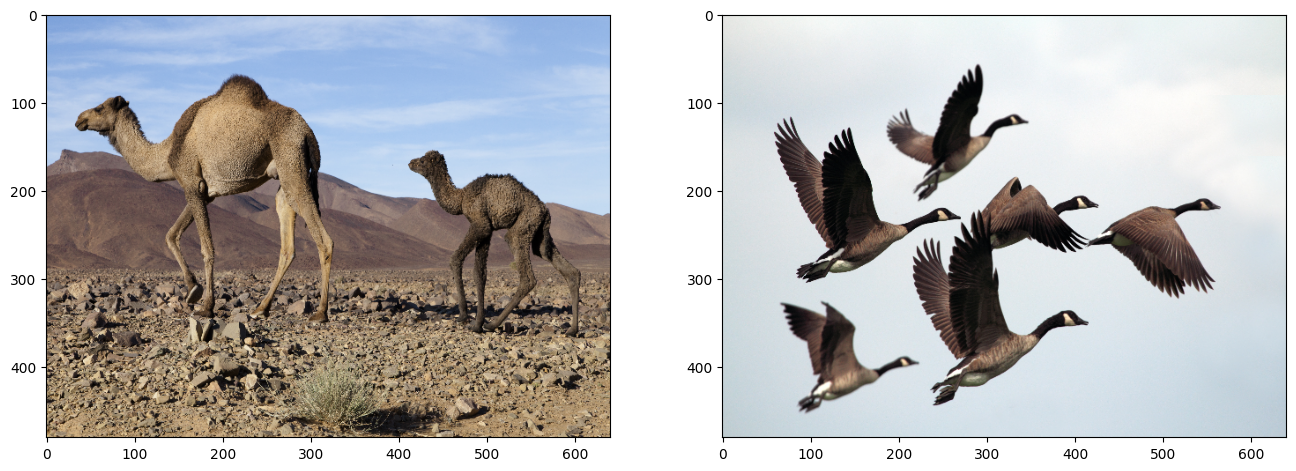

In [8]:
# Show some examples from dataset
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
image_utils.display_image(dset[0][0], axes[0])
image_utils.display_image(dset[1][0], axes[1])

<Axes: >

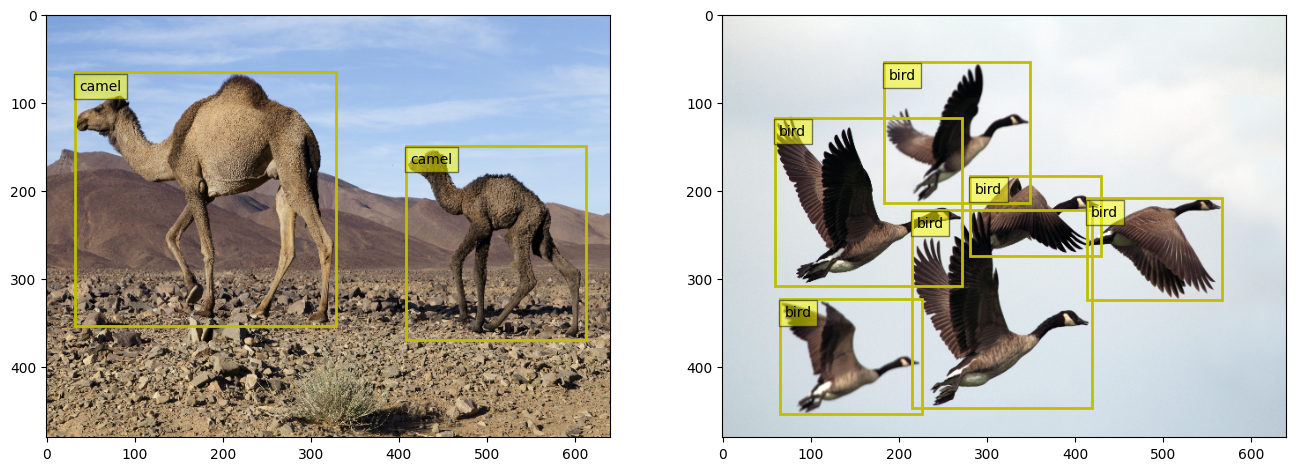

In [9]:
# Show bounding boxes on examples
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
image_utils.display_image(dset[0][0], axes[0])
image_utils.display_image(dset[1][0], axes[1])
rcnn_utils.draw_bounding_boxes(axes[0], *[*dset[0]][1:], index2name)
rcnn_utils.draw_bounding_boxes(axes[1], *[*dset[1]][1:], index2name)

In [10]:
# Create data loader object
dloader = DataLoader(dset, batch_size=2)
sample = next(iter(dloader))
images, gt_boxes, classes = sample
print('Img shape:', images.shape)
print('Ground truth boxes:', gt_boxes, sep='\n')
print('Classes:', classes, sep='\n')

Img shape: torch.Size([2, 3, 480, 640])
Ground truth boxes:
tensor([[[ 32.2824,  65.2389, 328.1726, 352.8849],
         [408.5333, 148.9911, 612.8032, 368.4920],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000]],

        [[413.2392, 208.3540, 566.8173, 323.4655],
         [215.0369, 221.7805, 418.7608, 446.4885],
         [182.7765,  53.6920, 348.1380, 213.6991],
         [ 58.8863, 116.6513, 271.8745, 307.2566],
         [281.0667, 182.5133, 429.0196, 273.1859],
         [ 65.0447, 322.8672, 226.2996, 453.4159]]])
Classes:
tensor([[ 0.,  0., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.]])


In [11]:
# Get backbone
resnet = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.DEFAULT)
backbone = torch.nn.Sequential(*list(resnet.children())[:8])

In [12]:
backbone_out = backbone(sample[0])

In [13]:
# Get output shape
b, out_c, out_h, out_w = backbone_out.shape
print(b, out_c, out_h, out_w)

2 2048 15 20


In [14]:
# Get size difference factor between input image and output feature map
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
print(height_scale_factor, width_scale_factor)

32 32


<Axes: >

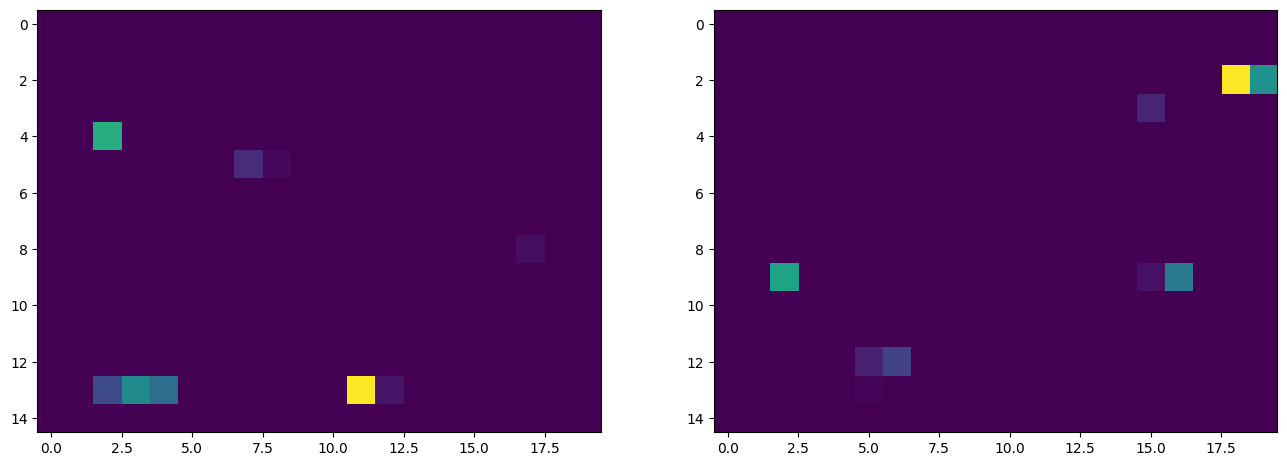

In [15]:
# Show some weights from trained backbone
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# Second index of backbone_out can be configured for showing other maps.
image_utils.display_image(backbone_out[0][3].detach().numpy(), axes[0])
image_utils.display_image(backbone_out[1][6].detach().numpy(), axes[1])

In [16]:
# Get x, y coordinates of anchor points on feature map
# and project them to input image size
x_anchors, y_anchors = rcnn_utils.generate_anchors((out_h, out_w))
print('Feature map anchors:', x_anchors, y_anchors, sep='\n')
projected_x_anchors = x_anchors * width_scale_factor
projected_y_anchors = y_anchors * height_scale_factor
print('Anchors scaled to image sizes:',
      projected_x_anchors, projected_y_anchors, sep='\n')

Feature map anchors:
tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,  7.5000,
         8.5000,  9.5000, 10.5000, 11.5000, 12.5000, 13.5000, 14.5000, 15.5000,
        16.5000, 17.5000, 18.5000, 19.5000])
tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,  7.5000,
         8.5000,  9.5000, 10.5000, 11.5000, 12.5000, 13.5000, 14.5000])
Anchors scaled to image sizes:
tensor([ 16.,  48.,  80., 112., 144., 176., 208., 240., 272., 304., 336., 368.,
        400., 432., 464., 496., 528., 560., 592., 624.])
tensor([ 16.,  48.,  80., 112., 144., 176., 208., 240., 272., 304., 336., 368.,
        400., 432., 464.])


<Axes: >

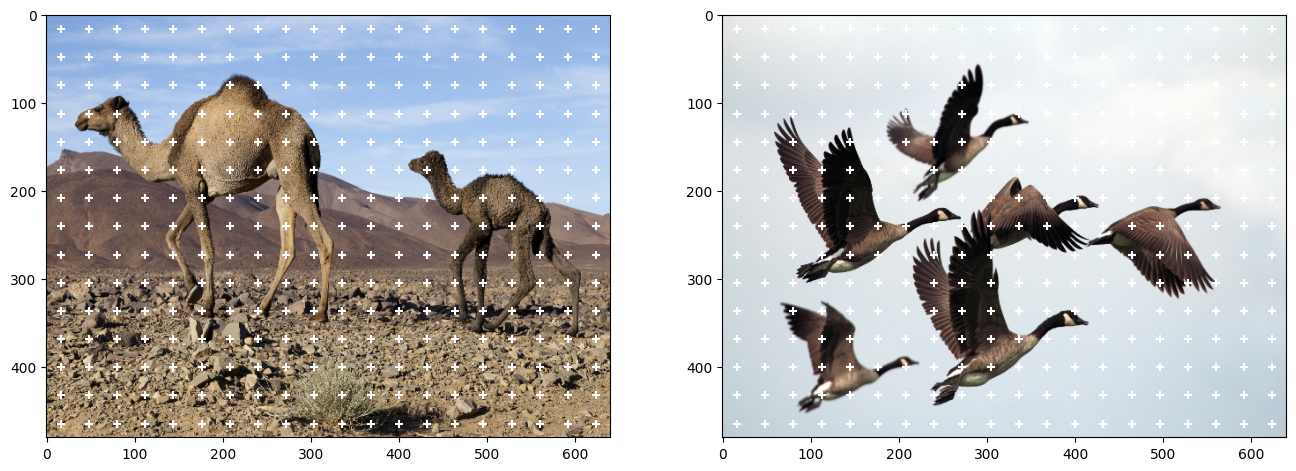

In [17]:
# Show anchor points
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
image_utils.display_image(dset[0][0], axes[0])
image_utils.display_image(dset[1][0], axes[1])
rcnn_utils.show_anchors(projected_x_anchors, projected_y_anchors, axes[0])
rcnn_utils.show_anchors(projected_x_anchors, projected_y_anchors, axes[1])

In [18]:
# Generate anchors' bboxes
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
# number of anchor boxes for each anchor point
# n_anc_boxes = len(anc_scales) * len(anc_ratios)
anc_bboxes_grid = rcnn_utils.generate_anchor_boxes(
    x_anchors, y_anchors, anc_scales, anc_ratios, (out_h, out_w))
all_anc_bboxes = anc_bboxes_grid.repeat(len(dset), 1, 1, 1, 1)

<Axes: >

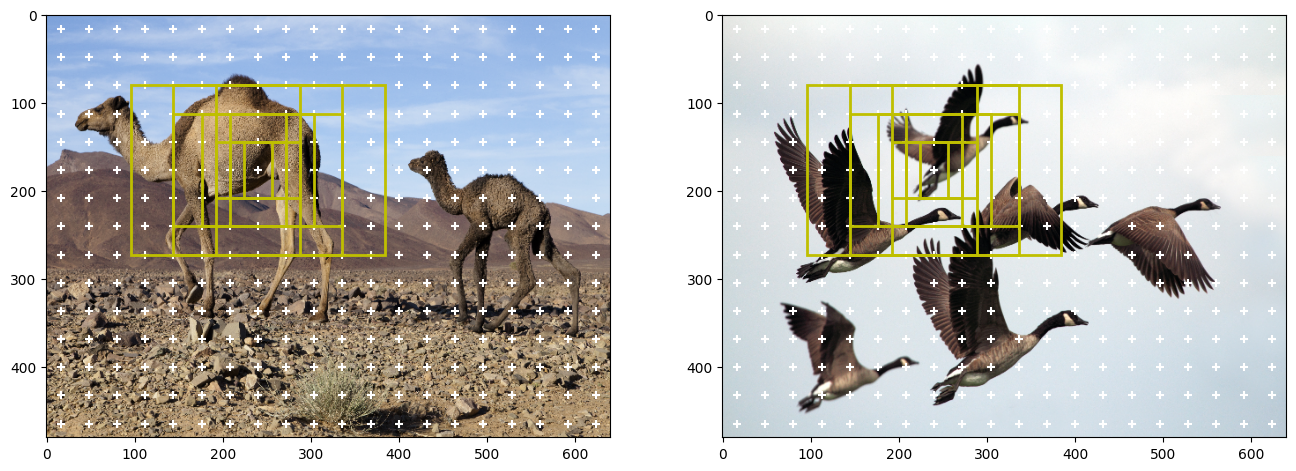

In [19]:
# Show some example of anchor and its bboxes
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
image_utils.display_image(dset[0][0], axes[0])
image_utils.display_image(dset[1][0], axes[1])
rcnn_utils.show_anchors(projected_x_anchors, projected_y_anchors, axes[0])
rcnn_utils.show_anchors(projected_x_anchors, projected_y_anchors, axes[1])

projected_bboxes = rcnn_utils.project_bboxes(
    anc_bboxes_grid, width_scale_factor, height_scale_factor)

selected_bboxes = projected_bboxes[5, 7, :, :]

rcnn_utils.draw_bounding_boxes(
    axes[0], selected_bboxes.reshape(-1, 4), line_width=2)
rcnn_utils.draw_bounding_boxes(
    axes[1], selected_bboxes.reshape(-1, 4), line_width=2)

In [20]:
# Project ground truth from sample to feature map size
projected_gt = rcnn_utils.project_bboxes(
    gt_boxes.reshape(-1, 4), width_scale_factor,
    height_scale_factor, 'p2a').reshape(gt_boxes.shape)

In [21]:
# Get anchors by thresholds
pos_thresh = 0.7
neg_thresh = 0.3

(pos_anc_idxs, neg_anc_idxs, pos_b_idxs,
 pos_ancs, neg_ancs, pos_anc_conf_scores,
 gt_class_pos, gt_offsets) = rcnn_utils.get_required_anchors(
     all_anc_bboxes.reshape(b, -1, 4), projected_gt, classes,
     pos_thresh, neg_thresh)

In [22]:
# Split anchors batch into samples
pos_anc_img_proj = rcnn_utils.project_bboxes(
    pos_ancs, width_scale_factor, height_scale_factor)
neg_anc_img_proj = rcnn_utils.project_bboxes(
    neg_ancs, width_scale_factor, height_scale_factor)

anc_idx_1 = torch.where(pos_b_idxs == 0)
anc_idx_2 = torch.where(pos_b_idxs == 1)

pos_anc_1 = pos_anc_img_proj[anc_idx_1]
pos_anc_2 = pos_anc_img_proj[anc_idx_2]

neg_anc_1 = neg_anc_img_proj[anc_idx_1]
neg_anc_2 = neg_anc_img_proj[anc_idx_2]

<Axes: >

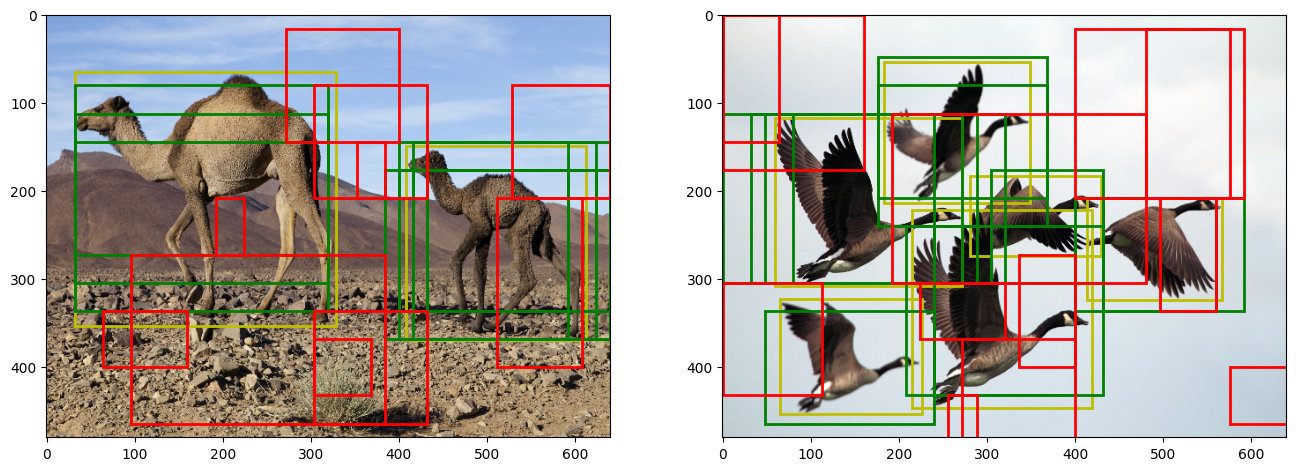

In [23]:
# Show gotten anchor boxes
fix, axes = plt.subplots(1, 2, figsize=(16, 8))

image_utils.display_image(dset[0][0], axes[0])
image_utils.display_image(dset[1][0], axes[1])

rcnn_utils.draw_bounding_boxes(axes[0], gt_boxes[0])
rcnn_utils.draw_bounding_boxes(axes[1], gt_boxes[1])

rcnn_utils.draw_bounding_boxes(axes[0], pos_anc_1, color='g')
rcnn_utils.draw_bounding_boxes(axes[1], pos_anc_2, color='g')

rcnn_utils.draw_bounding_boxes(axes[0], neg_anc_1, color='r')
rcnn_utils.draw_bounding_boxes(axes[1], neg_anc_2, color='r')

In [24]:
# Get the model
img_size = (img_height, img_width)
n_cls = len(name2index) - 1
roi_size = (2, 2)

rcnn_detector = rcnn_model.RCNN_Detector(input_size=(img_height, img_width),
                                         n_cls=n_cls,
                                         roi_size=roi_size,
                                         anc_scales=anc_scales,
                                         anc_ratios=anc_ratios,
                                         pos_anc_thresh=pos_thresh,
                                         neg_anc_thresh=neg_thresh)

In [25]:
# Get optimizer
lr = 0.001
optimizer = optim.Adam(rcnn_detector.parameters(), lr=lr)

In [26]:
# Training
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
n_epoch = 1000
rcnn_detector = rcnn_detector.to(device=device)
rcnn_detector.train()
loss_log = []

for i in tqdm(range(n_epoch)):
    ep_losses = []
    total_loss = 0
    for batch in dloader:
        images, gt_boxes, gt_classes = batch
        images = images.to(device=device)
        gt_boxes = gt_boxes.to(device=device)
        gt_classes = gt_classes.to(device=device)

        proposals, classes, loss = rcnn_detector(images, gt_boxes, gt_classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_losses.append(loss.item())
    loss_log.append(torch.mean(torch.tensor(ep_losses)))

100%|██████████| 1000/1000 [02:05<00:00,  7.94it/s]


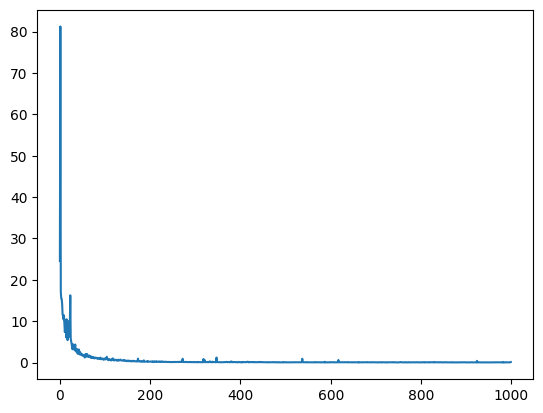

In [27]:
# Show loss curve
plt.plot(loss_log)

In [28]:
torch.save(rcnn_detector.state_dict(), 'best_model.pt')

In [31]:
# rcnn_detector.load_state_dict(torch.load('best_model.pt'))
rcnn_detector.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [48]:
# Evaluation
batch = next(iter(dloader))
images, gt_boxes, classes = batch
rcnn_detector = rcnn_detector.cpu()
rcnn_detector.eval()

proposals, confidences = rcnn_detector(
    images, conf_thresh=0.99, nms_thresh=0.05)
# rcnn_detector.train()
# proposals, confidence, loss = rcnn_detector(images, gt_boxes, classes)

In [49]:
proposals

[tensor([[12.6676,  4.7029, 19.2034, 11.6234],
         [ 0.9946,  2.1898, 10.2072, 10.9136]]),
 tensor([[10.8627, 11.0717, 17.9393, 14.6053],
         [ 8.7321,  5.6969, 13.4228,  8.5409],
         [ 5.5859, 10.4410, 11.3758, 13.6093],
         [ 1.7427,  3.6883,  8.5492,  9.6771],
         [12.8882,  6.5095, 17.7613, 10.1210],
         [11.1012, -0.2855, 16.4924,  5.4899]])]

In [50]:
# Normalize output
for i in range(len(proposals)):
    if proposals[i].shape[0] != 0:
        proposals[i] = rcnn_utils.project_bboxes(
            proposals[i], width_scale_factor, height_scale_factor)

        for j in range(4):
            proposals[i][:, j][proposals[i][:, j] < 0] = 0
            if j % 2 == 0:
                proposals[i][:, j][proposals[i][:, j] > img_width] = img_width - 1
            else:
                proposals[i][:, j][proposals[i][:, j] > img_height] = img_height - 1


In [51]:
proposals

[tensor([[405.3621, 150.4943, 614.5085, 371.9500],
         [ 31.8263,  70.0723, 326.6317, 349.2343]]),
 tensor([[347.6064, 354.2956, 574.0579, 467.3697],
         [279.4274, 182.3009, 429.5309, 273.3087],
         [178.7502, 334.1116, 364.0250, 435.4985],
         [ 55.7659, 118.0263, 273.5759, 309.6682],
         [412.4227, 208.3029, 568.3608, 323.8719],
         [355.2378,   0.0000, 527.7555, 175.6764]])]

In [52]:
# Get predicted classes
predicted_cls = []
for b_confs in confidences:
    predicted_cls.append(torch.argmax(b_confs, dim=1))

In [53]:
predicted_cls

[tensor([0, 0]), tensor([1, 1, 1, 1, 1, 1])]

<Axes: >

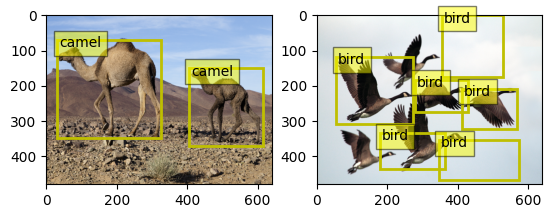

In [54]:
# Display predictions
fig, axes = plt.subplots(1, 2)
image_utils.display_image(images[0], axes[0])
image_utils.display_image(images[1], axes[1])

rcnn_utils.draw_bounding_boxes(
    axes[0], proposals[0], predicted_cls[0], index2name)
rcnn_utils.draw_bounding_boxes(
    axes[1], proposals[1], predicted_cls[1], index2name)

